In [1]:
import numpy as np
import tqdm
import time
import csv
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline


global bin_counts
global bin_limits
global bin_drop_percentage
global num_bins
global bin_count_idx_vals

num_bins = 40


In [2]:
'''
flip_test = np.array(images_center[0:2])
flip_test_angle = np.array(steering_vals[0:2])

flip_test_imgs_res, flip_test_angle_res = flip_imgs(flip_test, flip_test_angle)

final_res = np.append(flip_test, flip_test_imgs_res, axis=0)

print (flip_test.shape)
print (flip_test_imgs_res.shape)
print (final_res.shape)

'''


'\nflip_test = np.array(images_center[0:2])\nflip_test_angle = np.array(steering_vals[0:2])\n\nflip_test_imgs_res, flip_test_angle_res = flip_imgs(flip_test, flip_test_angle)\n\nfinal_res = np.append(flip_test, flip_test_imgs_res, axis=0)\n\nprint (flip_test.shape)\nprint (flip_test_imgs_res.shape)\nprint (final_res.shape)\n\n'

In [3]:
def aws_filename(fnames):
    new_paths =[]
    for fname in fnames:
        source_path = fname
        foldername= source_path.split('/')[-3]
        filename= source_path.split('/')[-1]
        current_path = './collected_data/' + foldername + '/IMG/' + filename
        new_paths.append(current_path)
    return new_paths

def load_imgs_from_path(paths):
    images =[]
    for img_path in paths:
        new_img = mpimg.imread(img_path)
        images.append(new_img)
    return images

9416
2355
./collected_data/run4_extra_data_difficult_sections/IMG/center_2017_03_08_20_21_31_129.jpg


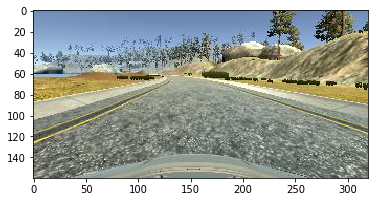

In [4]:
#csv parsing from collected data

fnames = ['./collected_data/run1/driving_log.csv', './collected_data/run2_reverse/driving_log.csv', './collected_data/run3_recover/driving_log.csv', './collected_data/run4_extra_data_difficult_sections/driving_log.csv', './collected_data/run5_new_recovery/driving_log.csv', './collected_data/run7_second_track_center/driving_log.csv','./collected_data/run8_second_track_extra/driving_log.csv']
lines = []

for fname in fnames: 
    with open(fname) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
           lines.append(line) 

images = []
measurements = []

    
lines = np.array(lines)
lines_train, lines_validation = train_test_split(lines, test_size=0.2)

print (len(lines_train))
print (len(lines_validation))

images_center_path = aws_filename(np.array(lines_train[:,0]))
images_left_path = aws_filename(np.array(lines_train[:,1]))
images_right_path = aws_filename(np.array(lines_train[:,2]))
steering_vals = np.array(lines_train[:,3])
steering_vals = steering_vals.astype(float)
num_train_samples = len(steering_vals)*7

images_center_path_val = aws_filename(np.array(lines_validation[:,0]))
images_left_path_val = aws_filename(np.array(lines_validation[:,1]))
images_right_path_val = aws_filename(np.array(lines_validation[:,2]))
steering_vals_val = np.array(lines_validation[:,3])
steering_vals_val = steering_vals_val.astype(float)
num_val_samples = len(steering_vals_val)*7




   
    
print(images_center_path[0])
my_img_path = './collected_data/run1/IMG/center_2017_02_27_21_47_36_087.jpg'
my_img = mpimg.imread(my_img_path)
#print (len(images_center))
plt.imshow(my_img)

#images_center = np.array(images_center)
#print (images_center.shape)

#plt.imshow(images_center[0])

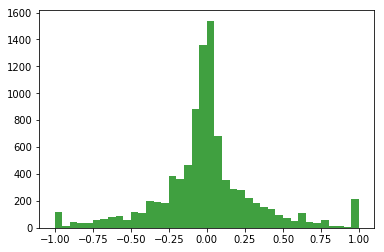

In [5]:
n, bins, patches = plt.hist(steering_vals, num_bins, facecolor='green', alpha=0.75)

In [6]:
def flip_imgs(images, angles):
    flipped_imgs = []
    flipped_angles = []
    for image, angle in zip(images,angles):
        flipped_imgs.append(cv2.flip(image,1))
        flipped_angles.append(-1.0 * float(angle))
        
    flipped_imgs = np.array(flipped_imgs)
    flipped_angles = np.array(flipped_angles)
    return flipped_imgs, flipped_angles

def flip_angles(angles):
    flipped_angles = []
    for angle in angles:
        flipped_angles.append(-1.0 * float(angle))
    flipped_angles = np.array(flipped_angles)
    return flipped_angles

    
def getlr_steering(steering_vals):
    left_steering = []
    right_steering = []
    for steer in steering_vals:
        left_steering.append(0.25 + steer)
        right_steering.append(-0.25 + steer)
    left_steering = np.clip(np.array(left_steering), a_max=1, a_min=-1)
    right_steering = np.clip(np.array(right_steering), a_max=1, a_min=-1)

    return left_steering, right_steering

def find_bin (angle):
    global bin_limits
    bin_it = (np.nonzero(angle <= bin_limits)[0][0]-1)
    return bin_it

        
def drop_img(img, angle):
    global bin_drop_percentage
    drop = np.random.uniform()
    if drop <= bin_drop_percentage[find_bin(angle)]:
        return True
    else:
        return False
    
    
def drop_imgs(imgs, angles):
    X = []
    y = []
    for img, angle in zip (imgs, angles):
        if drop_img(img, angle) == False:
            X.append(img)
            y.append(angle)
    
    return np.array(X), np.array(y)

def drop_angles(angles):
    global bin_drop_percentage
    y = []
    for angle in angles:
        drop = np.random.uniform()
        if drop >= bin_drop_percentage[find_bin(angle)]:
            y.append(angle)
    
    return np.array(y)

In [7]:
def rnd_brightness(img):
    # randomizes the brightness levels on image data and clips max/min values to 1 & 0 respectively
    brightness_param = np.random.rand(1)+0.5
    img =(img*brightness_param)
    img = np.clip(img, a_max=1, a_min=0)
    return img

def rot_image(img,ang_range):
    # This fn modifies the input image with random values for rotation using OpenCV fns
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)    
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    return img


def trans_img(img, trans_delta):
    # Translation
    y_range = 10
    rows,cols,ch = img.shape    
    tr_x = trans_delta
    tr_y = y_range*np.random.uniform()-y_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    return img    

##################### instead of filling with random imgs fill with this, not over generate, generate only required amount
#def gen_extra_imgs (imgs, angles, ang_range = 10, num_it_per_img = 3, total_num_to_gen):
def gen_extra_imgs (imgs, angles, ang_range = 10, num_it_per_img = 1):
    #augment imgs with rotation, brightness and shadows (not uniform)
    new_imgs = []
    new_angles = []
    for img, angle in zip(imgs, angles):
        for i in range(num_it_per_img):
            new_imgs.append(rot_image(rnd_brightness(img),ang_range=ang_range))
            new_angles.append(angle)
    
    return np.array(new_imgs), np.array(new_angles)
        
        
def find_appropiated_new_angle(angle):
    global imgs_to_gen
    bins_to_fill = np.array(np.nonzero(imgs_to_gen))[0]
    max_num_pixel_tr = 50
    count = 0
    if len(bins_to_fill) > 0:
        while True:
            rand_angle_bin_num = np.random.randint(low=0,high=len(bins_to_fill))
            rand_angle_bin = bins_to_fill[rand_angle_bin_num]
            rand_angle_variance = 2/num_bins * np.random.uniform()
            rand_angle = bin_limits[rand_angle_bin] + rand_angle_variance
            angle_delta_pixels = np.floor((angle-rand_angle)/0.008)
            if np.abs(angle_delta_pixels) < max_num_pixel_tr:
                imgs_to_gen[rand_angle_bin] -= 1
                return rand_angle, angle_delta_pixels
            elif count >=10:
                return 0, 9999
            else:
                count += 1
    else:
        return 0, 9999

        
        
def gen_extra_angles (imgs, angles, num_it_per_img = 3):
    #translate imgs and gen new angles (uniform - ish)
    new_imgs = []
    new_angles = []
    for img, angle in zip(imgs, angles):
        for i in range(num_it_per_img):
            #print('gen_angle_it: ', i)
            rand_angle, angle_delta_pixels = find_appropiated_new_angle(angle)
            #print('rand_angle: ', rand_angle)
            #print('angle_delta_pixels: ', angle_delta_pixels)
            if angle_delta_pixels != 9999:
                new_imgs.append(trans_img(img, angle_delta_pixels))
                new_angles.append(rand_angle)
                #print('new_angles: ', len(new_angles))
                #print('new_imgs: ', len(new_imgs))

    return np.array(new_imgs), np.array(new_angles)


def gen_extra_angles_only_angles (angles, num_it_per_img = 3):
    #translate imgs and gen new angles (uniform - ish)
    new_angles = []
    for angle in angles:
        for i in range(num_it_per_img):
            rand_angle, angle_delta_pixels = find_appropiated_new_angle(angle)
            if angle_delta_pixels != 9999:
                new_angles.append(rand_angle)
    return np.array(new_angles)

def calc_imgs_to_gen(gen_angles, old_mean):
    global num_bins
    global bin_limits
    num_angles, num_angles_count = np.unique(gen_angles, return_counts=True)
    angle_bins, bin_limits = pd.cut(gen_angles,num_bins, retbins=True)
    bin_count_idx_vals = pd.value_counts(angle_bins)
    bin_count_idx_vals = bin_count_idx_vals.sort_index()
    bin_count = bin_count_idx_vals.values
    #return np.clip(np.floor(bin_count_idx_vals.mean() - bin_count), a_min=0, a_max=10000)
    return np.array(np.clip(np.floor(old_mean - bin_count), a_min=0, a_max=10000)).astype(np.int, copy=False)


def calc_bin_drop_percentage(gen_angles):
    global num_bins
    global bin_limits
    num_angles, num_angles_count = np.unique(gen_angles, return_counts=True)
    angle_bins, bin_limits = pd.cut(gen_angles,num_bins, retbins=True)
    bin_count_idx_vals = pd.value_counts(angle_bins)
    bin_count_idx_vals = bin_count_idx_vals.sort_index()
    bin_count = bin_count_idx_vals.values
    return np.clip((1-(bin_count_idx_vals.mean()/bin_count)), a_min=0, a_max=10), bin_count_idx_vals.mean()

initial angles:  (9416,)
added lr & flip:  (37664,)
dropped:  (23156,)
added newimgs generated:  (46312,)
target imgs_to_gen:  [ 619 1699 1609 1619 1349 1447 1413 1025 1157 1161  573  515   87   43   67
   35   13   23    0    0   39    0    0    0    0    0   29  251  717  825
 1051 1207 1165 1369 1081 1539 1683 1559 1755  547]
imgs_to_gen afterwards:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
new angles generated:  (29271,)
final size:  (75583,)


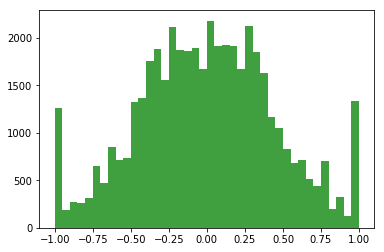

In [8]:
#X_train = np.array(images_center[0:9])
#y_train = np.array(steering_vals[0:9])

mult_new_imgs = 1
mult_new_angles = 5

gen_angles = steering_vals
print ('initial angles: ',gen_angles.shape)
flipped_angles = flip_angles(steering_vals)
left_steering_angles, right_steering_angles = getlr_steering(steering_vals)


gen_angles=np.append(gen_angles, flipped_angles)
gen_angles=np.append(gen_angles, left_steering_angles)
gen_angles=np.append(gen_angles, right_steering_angles)
 
print ('added lr & flip: ',gen_angles.shape)

bin_drop_percentage, old_mean = calc_bin_drop_percentage(gen_angles)
bin_drop_percentage_aux = np.array(bin_drop_percentage)
gen_angles_drop = drop_angles(gen_angles)
print ('dropped: ',gen_angles_drop.shape)

gen_angles=np.append(gen_angles_drop, gen_angles_drop)
#gen_angles=np.append(gen_angles, gen_angles_drop)
#gen_angles=np.append(gen_angles, gen_angles_drop)

print ('added newimgs generated: ',gen_angles.shape)

imgs_to_gen = calc_imgs_to_gen(gen_angles, old_mean*(mult_new_imgs+1))
imgs_to_gen_aux = np.array(imgs_to_gen)
print ('target imgs_to_gen: ',imgs_to_gen)

new_angles = gen_extra_angles_only_angles(gen_angles, num_it_per_img=mult_new_angles)

print ('imgs_to_gen afterwards: ',imgs_to_gen)

gen_angles_final = np.append(gen_angles, new_angles)

n, bins, patches = plt.hist(gen_angles, num_bins, facecolor='green', alpha=0.75)

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

#print (X_train.shape)
print ('new angles generated: ',new_angles.shape)
print ('final size: ',gen_angles_final.shape)

[ 619 1699 1609 1619 1349 1447 1413 1025 1157 1161  573  515   87   43   67
   35   13   23    0    0   39    0    0    0    0    0   29  251  717  825
 1051 1207 1165 1369 1081 1539 1683 1559 1755  547]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.30148368  0.55268409  0.5395599   0.3483737   0.3152      0.54687199
  0.73858967  0.70938272  0.55374408  0.33783404  0.44284024  0.60519916
  0.46101889  0.14710145  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]


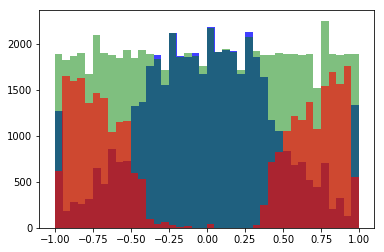

In [9]:


#bin_count_data=bin_count.data.tolist()
#print(bin_count.mean())
#print(bin_count.median())
#print(bin_count_idx_vals)
#print(bin_count)
#print(bin_limits)
#print(np.nonzero(0.19 <= bin_limits)[0][0]-1)

n, bins, patches = plt.hist(gen_angles, num_bins, facecolor='blue', alpha=0.75)
n, bins, patches = plt.hist(gen_angles_final, num_bins, facecolor='green', alpha=0.5)
n, bins, patches = plt.hist(new_angles, num_bins, facecolor='red', alpha=0.625)

bin_drop_percentage = bin_drop_percentage_aux
imgs_to_gen = imgs_to_gen_aux

print (imgs_to_gen)
print (bin_drop_percentage)

global sample_counter

sample_counter =0

In [10]:
def generator(imgs_center_paths, imgs_left_paths, imgs_right_paths, all_steering_values, batch_size):
    num_imgs = len(all_steering_values)
    last_offset = np.floor(num_imgs/batch_size)*batch_size
    target_batch_size= int(np.floor(batch_size*2.5))
    img_gen_mult = 5
    #global sample_counter
    while 1:
        shuffle(imgs_center_paths, imgs_left_paths, imgs_right_paths, all_steering_values)
        #print (sample_counter)
        #sample_counter = 0
        for offset in range(0,num_imgs, batch_size):
            #if (offset/batch_size)%200 ==0:
                #print('### - Iteration: ', offset/batch_size, ' / 1464')
            #sample_counter += 1
            images = []
            angles = []
            images_center = load_imgs_from_path(imgs_center_paths[offset:offset+batch_size])
            images_left = load_imgs_from_path(imgs_left_paths[offset:offset+batch_size])
            images_right = load_imgs_from_path(imgs_right_paths[offset:offset+batch_size])
            steering_values = all_steering_values[offset:offset+batch_size]
            
            flipped_images, flipped_angles = flip_imgs(images_center, steering_values)
            left_steering_vals, right_steering_vals = getlr_steering(steering_values)

            X_train = np.append(np.array(images_center), flipped_images, axis=0)
            X_train = np.append(X_train, images_left, axis=0)
            X_train = np.append(X_train, images_right, axis=0)
            y_train = np.append(np.array(steering_values), flipped_angles, axis=0)
            y_train = np.append(y_train, left_steering_vals, axis=0)
            y_train = np.append(y_train, right_steering_vals, axis=0)

            if y_train.shape[0] == 4 * batch_size:
                X_train, y_train = drop_imgs (X_train, y_train)
            #else:
                #print ('---Too small --y_shape pre drop---')
                #print ('X_train: ', X_train.shape)
                #print ('y_train: ', y_train.shape)

           
            if y_train.shape[0]<target_batch_size:
                imgs_to_load = int(target_batch_size-y_train.shape[0])
                #print ('num_imgs_toload',imgs_to_load)
                ids_first_imgs_to_load = np.random.randint(low=0,high=(num_imgs-target_batch_size))
                #print ('ids_first_imgs_to_load: ', ids_first_imgs_to_load)
                additional_images = np.array(load_imgs_from_path(imgs_center_paths[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load]))
                additional_angles = np.array(all_steering_values[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load])
                #print ('additional_images: ',np.array(additional_images).shape)
                #print ('additional_angles: ',additional_angles.shape)
                if additional_angles.shape[0] != 0 and additional_images.shape[0]!=0 :
                    #print ('X_train: ', X_train.shape)
                    #print ('y_train: ', y_train.shape)
                    #print ('additional_images: ', additional_images.shape)
                    #print ('additional_angles: ', additional_angles.shape)
                    X_train = np.append(X_train, additional_images, axis=0)
                    y_train = np.append(y_train, additional_angles, axis=0)
                else:
                    print ('mismatched shape 1')
                    #print ('X_train: ', X_train.shape)
                    #print ('y_train: ', y_train.shape)
                    #print ('additional_images: ', np.array(additional_images).shape)
                    #print ('additional_angles: ', additional_angles.shape)
            else:
                #print('-bigger than target_batch_size')
                X_train=X_train[0:target_batch_size]
                y_train=y_train[0:target_batch_size]
            
            #print ('aftr img_gen adj - y_shape')
            #print (y_train.shape)

            new_extra_imgs, new_extra_imgs_angles = gen_extra_imgs(X_train, y_train)
            #print ('new_extra_imgs: ',new_extra_imgs.shape)
            #print ('new_extra_imgs_angles: ',new_extra_imgs_angles.shape)
            if new_extra_imgs_angles.shape[0] != 0:
                X_train = np.append(X_train, new_extra_imgs, axis=0)
                y_train = np.append(y_train, new_extra_imgs_angles, axis=0)
            else:
                print ('mismatched shape 2')    
            #print ('aftr genimgs - y_shape')
            #print (y_train.shape)

            new_imgs_extra_angle, new_extra_angle = gen_extra_angles(X_train, y_train)
            #print ('newangles_imgs: ',new_imgs_extra_angle.shape)
            #print ('newangles: ',new_extra_angle.shape)
            if new_extra_angle.shape[0] != 0:
                X_train = np.append(X_train, new_imgs_extra_angle, axis=0)
                y_train = np.append(y_train, new_extra_angle, axis=0)
            #else:
                #print ('mismatched shape 3') 
                #print ('aftr genangles - y_shape')
            #print (y_train.shape)
            
            if y_train.shape[0]<img_gen_mult*target_batch_size:
                imgs_to_load = int(img_gen_mult*target_batch_size-y_train.shape[0])
                #print ('num_imgs_to_load_aftergen',imgs_to_load)
                ids_first_imgs_to_load = np.random.randint(low=0,high=(num_imgs-img_gen_mult*target_batch_size))
                X_train = np.append(X_train, load_imgs_from_path(imgs_center_paths[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load]), axis=0)
                y_train = np.append(y_train, all_steering_values[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load], axis=0)
            else:
                #print('--bigger than 10*target_batch_size')
                X_train=X_train[0:img_gen_mult*target_batch_size]
                y_train=y_train[0:img_gen_mult*target_batch_size]
            #print ('aftr angle_adj - y_shape')
            #print (y_train.shape)
            #print (X_train.shape)
            #if offset == last_offset:
                #print (sample_counter)
                #sample_counter = 0
                
            yield shuffle(X_train, y_train)
            

# from https://github.com/Lasagne/Lasagne/issues/12
def threaded_generator(generator, num_cached=10):
    import queue
    queue = queue.Queue(maxsize=num_cached)
    sentinel = object()  # guaranteed unique reference

    # define producer (putting items into queue)
    def producer():
        for item in generator:
            queue.put(item)
        queue.put(sentinel)

    # start producer (in a background thread)
    import threading
    thread = threading.Thread(target=producer)
    thread.daemon = True
    thread.start()

    # run as consumer (read items from queue, in current thread)
    item = queue.get()
    while item is not sentinel:
        yield item
        queue.task_done()
        item = queue.get()  

In [11]:
#imgs_to_gen = np.clip(np.floor(bin_count_idx_vals.mean() - bin_count), a_min=0, a_max=10000)
#print (imgs_to_gen)
#print (imgs_to_gen.sum())
#print (bin_count_idx_vals.mean())
#print (bin_count[np.nonzero(imgs_to_gen)].sum())
#bins_to_fill = np.array(np.nonzero(imgs_to_gen))[0]

#print (bins_to_fill)


#rand_angle_bin_num = np.random.randint(low=0,high=len(bins_to_fill))
#rand_angle_bin = bins_to_fill[rand_angle_bin_num]
#rand_angle_variance = 2/num_bins * np.random.uniform()
#rand_angle = bin_limits[rand_angle_bin] + rand_angle_variance
#print (rand_angle_variance)
#print (rand_angle_bin)
#print (rand_angle)
#print (bin_limits)

#print (steering_vals.min())


In [12]:
m_batch_size=50
train_generator = generator(images_center_path, images_left_path, images_right_path, steering_vals, batch_size=m_batch_size)
validation_generator = generator(images_center_path_val, images_left_path_val, images_right_path_val, steering_vals_val, batch_size=m_batch_size)

#print(steering_vals.shape)
#new_vals_rn = np.random.randint(low=0,high=len(steering_vals), size=(1))
#print (new_vals_rn)
#print (steering_vals[new_vals_rn])
num_imgs = len(steering_vals)

print (num_imgs/m_batch_size)

#5856 vs 5864

#print (np.floor(num_imgs/m_batch_size)*m_batch_size)

#for offset in range(0,num_imgs, m_batch_size):
    #print (offset)

188.32


In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D, Convolution2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

model = Sequential()

model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(36,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(48,5,5,subsample=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(64,3,3))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(64,3,3))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
num_train_samples = 188*625
#num_train_samples = np.floor(gen_angles_final.shape[0])
num_val_samples = np.floor(num_train_samples*0.2)
history_object = model.fit_generator(train_generator, samples_per_epoch=num_train_samples, validation_data=validation_generator, nb_val_samples=num_val_samples, nb_epoch=7, verbose=2)

Using TensorFlow backend.


Epoch 1/4
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
534s - loss: 0.6828 - val_loss: 0.1126
Epoch 2/4
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
---Too small --y_shape pre drop---
X_train:  (20, 160, 320, 3)
y_train:  (20,)
460s - loss: 0.2977 - val_loss: 0.0912
Epoch 3/4
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
---Too small --y_shape pre drop---
X_train:  (20, 160, 320, 3)
y_train:  (20,)
464s - loss: 0.1790 - val_loss: 0.0807
Epoch 4/4
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
---Too small --y_shape pre drop---
X_train:  (20, 160, 320, 3)
y_train:  (20,)
454s - loss: 0.1244 - val_loss: 0.0769


In [14]:
#%debug

'''
additional_images = load_imgs_from_path(imgs_center_paths[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load])
                additional_angles = np.array(all_steering_values[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load])
                #print ('additional_images: ',np.array(additional_images).shape)
                #print ('additional_angles: ',additional_angles.shape)
                if additional_angles.shape[0] != 0 and np.array(additional_images).shape[0]!=0 :
                    X_train = np.append(X_train, additional_images, axis=0)
                    y_train = np.append(y_train, additional_angles, axis=0)
                else:

'''


"\nadditional_images = load_imgs_from_path(imgs_center_paths[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load])\n                additional_angles = np.array(all_steering_values[ids_first_imgs_to_load:ids_first_imgs_to_load+imgs_to_load])\n                #print ('additional_images: ',np.array(additional_images).shape)\n                #print ('additional_angles: ',additional_angles.shape)\n                if additional_angles.shape[0] != 0 and np.array(additional_images).shape[0]!=0 :\n                    X_train = np.append(X_train, additional_images, axis=0)\n                    y_train = np.append(y_train, additional_angles, axis=0)\n                else:\n\n"

dict_keys(['val_loss', 'loss'])


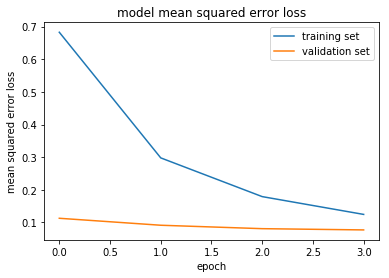

In [15]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [16]:
model.save('model_v6_second_track.h5')

In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D, Convolution2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

comma_model = Sequential()
comma_model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
comma_model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
comma_model.add(ELU())
comma_model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
comma_model.add(ELU())
comma_model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
comma_model.add(Flatten())
comma_model.add(Dropout(.2))
comma_model.add(ELU())
comma_model.add(Dense(512))
comma_model.add(Dropout(.5))
comma_model.add(ELU())
comma_model.add(Dense(1))

comma_model.compile(optimizer="adam", loss="mse")
#num_train_samples = np.floor(gen_angles_final.shape[0])
#num_val_samples = np.floor(num_train_samples*0.2)
num_train_samples = 188*625
num_val_samples = np.floor(num_train_samples*0.2)
comma_history_object = comma_model.fit_generator(train_generator, samples_per_epoch=num_train_samples, validation_data=validation_generator, nb_val_samples=num_val_samples, nb_epoch=3, verbose=2)

Epoch 1/3
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
---Too small --y_shape pre drop---
X_train:  (20, 160, 320, 3)
y_train:  (20,)
475s - loss: 1.0050 - val_loss: 0.0963
Epoch 2/3
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
462s - loss: 0.0898 - val_loss: 0.0867
Epoch 3/3
---Too small --y_shape pre drop---
X_train:  (64, 160, 320, 3)
y_train:  (64,)
---Too small --y_shape pre drop---
X_train:  (20, 160, 320, 3)
y_train:  (20,)
455s - loss: 0.0797 - val_loss: 0.0804


dict_keys(['val_loss', 'loss'])


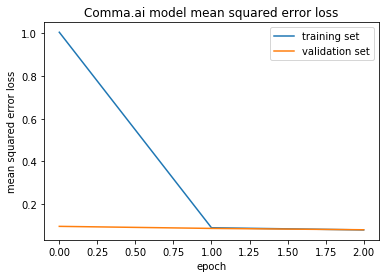

In [18]:
print(comma_history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(comma_history_object.history['loss'])
plt.plot(comma_history_object.history['val_loss'])
plt.title('Comma.ai model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [19]:
model.save('Comma_model_v3_second_track.h5')